# ColorSkim Machine Learning AI

Saat ini `item_description` untuk artikel ditulis dalam bentuk/format `nama_artikel + warna` dimana pemisahan `nama_artikel` dan `warna` bervariasi antar brand, beberapa menggunakan spasi, dash, garis miring dsbnya.

Pembelajaran mesin ini merupakan pembelajaran yang akan menerapkan jaringan saraf buatan (neural network) untuk mempelajari pola penulisan artikel yang bercampur dengan warna untuk mengekstrak warna saja dari artikel.

Akan dilakukan beberapa scenario modelling **Natural Language Procesing** untuk permasalahan *sequence to sequence* ini. Pada intinya kita akan membagi kalimat (`item_description`) berdasarkan kata per kata dan mengkategorisasikan masing - masing kata ke dalam satu dari dua kategori warna atau bukan_warna (logistik biner).



In [1]:
# import modul
import tensorflow as tf
from tensorflow.python.client import device_lib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wandb as wb
from rahasia import API_KEY_WANDB
tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()

In [2]:
# cek ketersediaan GPU untuk modeling
# NVidia GeForce MX250 - office
# NVidia GeForce GTX1060 - home
device_lib.list_local_devices()[1]

2022-07-07 02:19:30.636333: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-07 02:19:31.339774: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-07-07 02:19:31.407274: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-07-07 02:19:31.407962: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built witho

name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4821352448
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7840962591455291015
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1060, pci bus id: 0000:01:00.0, compute capability: 6.1"
xla_global_id: 416903419

In [3]:
# login ke wandb
wb.login(key=API_KEY_WANDB)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jpao (pri-data). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/jpao/.netrc


True

## Membaca data

In [4]:
# Membaca data ke dalam DataFrame pandas
data = pd.read_csv('data/setengah_dataset_artikel.csv')
data[:10]

,nama_artikel,kata,label,urut_kata,total_kata
0,ADISSAGE-BLACK/BLACK/RUNWHT,ADISSAGE,bukan_warna,1,4
1,ADISSAGE-BLACK/BLACK/RUNWHT,BLACK,warna,2,4
2,ADISSAGE-BLACK/BLACK/RUNWHT,BLACK,warna,3,4
3,ADISSAGE-BLACK/BLACK/RUNWHT,RUNWHT,warna,4,4
4,ADISSAGE-N.NAVY/N.NAVY/RUNWHT,ADISSAGE,bukan_warna,1,4
5,ADISSAGE-N.NAVY/N.NAVY/RUNWHT,N.NAVY,warna,2,4
6,ADISSAGE-N.NAVY/N.NAVY/RUNWHT,N.NAVY,warna,3,4
7,ADISSAGE-N.NAVY/N.NAVY/RUNWHT,RUNWHT,warna,4,4
8,3 STRIPE D 29.5-BASKETBALL NATURAL,3,bukan_warna,1,6
9,3 STRIPE D 29.5-BASKETBALL NATURAL,STRIPE,bukan_warna,2,6


## Eksplorasi data

In [5]:
# distribusi label dalam data
data['label'].value_counts()

bukan_warna    34174
warna          22577
Name: label, dtype: int64

## Konversi data ke dalam train dan test

In [6]:
from sklearn.model_selection import train_test_split
train_kata, test_kata, train_label, test_label = train_test_split(data['kata'].to_numpy(), data['label'].to_numpy(), test_size=0.2, random_state=42)
train_kata[:5], test_kata[:5], train_label[:5], test_label[:5]

(array(['INVIS', 'SOLRED', 'JR', 'REACT', 'WHITE'], dtype=object),
 array(['6', 'GA', 'NIKE', 'BLUE', 'BLACK'], dtype=object),
 array(['bukan_warna', 'warna', 'bukan_warna', 'bukan_warna', 'warna'],
       dtype=object),
 array(['bukan_warna', 'bukan_warna', 'bukan_warna', 'warna', 'warna'],
       dtype=object))

## Konversi label ke dalam numerik

In [7]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_label_encode = label_encoder.fit_transform(train_label)
test_label_encode = label_encoder.transform(test_label)
train_label_encode[:5], test_label_encode[:5]

(array([0, 1, 0, 0, 1]), array([0, 0, 0, 1, 1]))

## Model 0: model dasar

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Membuat pipeline untuk mengubah kata ke dalam tf-idf
model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

# Fit pipeline dengan data training
model_0.fit(X=train_kata, y=train_label_encode)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [9]:
# Evaluasi model_0 pada data test
model_0.score(X=test_kata, y=test_label_encode)

0.9935688485595983

In [10]:
# Membuat prediksi menggunakan data test
pred_model_0 = model_0.predict(test_kata)
pred_model_0

array([0, 0, 0, ..., 1, 1, 0])

In [11]:
# Membuat fungsi dasar untuk menghitung accuray, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
def hitung_metrik(target, prediksi):
    """
    Menghitung accuracy, precision, recall dan f1-score dari model klasifikasi biner
    
    Args:
        target: label yang sebenarnya dalam bentuk 1D array
        prediksi: label yang diprediksi dalam bentuk 1D array
        
    Returns:
        nilai accuracy, precision, recall dan f1-score dalam bentuk dictionary
    """
    # Menghitung akurasi model
    model_akurasi = accuracy_score(target, prediksi)
    # Menghitung precision, recall, f1-score dan support dari model
    model_presisi, model_recall, model_f1, _ = precision_recall_fscore_support(target, prediksi, average='weighted')
    
    hasil_model = {'akurasi': model_akurasi,
                   'presisi': model_presisi,
                   'recall': model_recall,
                   'f1-score': model_f1}
    
    return hasil_model

In [12]:
# Menghitung metrik dari model_0
model_0_metrik = hitung_metrik(target=test_label_encode, 
                               prediksi=pred_model_0)
model_0_metrik

{'akurasi': 0.9935688485595983,
 'presisi': 0.9935690437085363,
 'recall': 0.9935688485595983,
 'f1-score': 0.9935671438217326}

## Menyiapkan data (text) untuk model deep sequence

### Text Vectorizer Layer

In [13]:
# jumlah data (kata) dalam train_data
len(train_kata)

45400

In [14]:
# jumlah data unik (kata unik) dalam train_kata
jumlah_kata_train = len(np.unique(train_kata))
jumlah_kata_train

2940

In [15]:
# Membuat text vectorizer
from tensorflow.keras.layers import TextVectorization
vectorizer_kata = TextVectorization(max_tokens=jumlah_kata_train,
                                    output_sequence_length=1,
                                    standardize='lower')

2022-07-07 02:19:40.348562: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-07-07 02:19:40.349495: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-07-07 02:19:40.350497: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-07-07 02:19:40.352167: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-07-07 02:19:40.353028: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not op

In [16]:
# Mengadaptaasikan text vectorizer ke dalam train_kata
vectorizer_kata.adapt(train_kata)

In [17]:
# Test vectorizer kata
import random
target_kata = random.choice(train_kata)
print(f'Kata:\n{target_kata}\n')
print(f'Kata setelah vektorisasi:\n{vectorizer_kata([target_kata])}')

Kata:
BLUE

Kata setelah vektorisasi:
[[6]]


In [18]:
vectorizer_kata.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 2940,
 'standardize': 'lower',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 1,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None}

In [19]:
# Jumlah vocabulary dalam vectorizer_kata
jumlah_vocab = vectorizer_kata.get_vocabulary()
len(jumlah_vocab)

2938

### Membuat Text Embedding

In [20]:
# Membuat text embedding layer
from tensorflow.keras.layers import Embedding
kata_embed = Embedding(input_dim=len(jumlah_vocab),
                       output_dim=64,
                       mask_zero=True,
                       name='layer_token_embedding')

In [21]:
# Contoh vectorizer dan embedding
print(f'Kata sebelum vektorisasi:\n{target_kata}\n')
kata_tervektor = vectorizer_kata([target_kata])
print(f'\nKata sesudah vektorisasi (sebelum embedding):\n{kata_tervektor}\n')
kata_terembed = kata_embed(kata_tervektor)
print(f'\nKata setelah embedding:\n{kata_terembed}\n')
print(f'Shape dari kata setelah embedding:\n{kata_terembed.shape}')

Kata sebelum vektorisasi:
BLUE


Kata sesudah vektorisasi (sebelum embedding):
[[6]]


Kata setelah embedding:
[[[-0.03732216  0.04040921 -0.00940736  0.02958605 -0.04956089
   -0.00806015 -0.02693731 -0.04715559 -0.00017012  0.04184831
   -0.03318391  0.00201702 -0.04503196 -0.01768376 -0.03991426
    0.02226839 -0.01015774  0.03354723  0.00258589  0.02274612
   -0.00993731 -0.02601582  0.02152915 -0.03443115  0.01344189
   -0.01819754 -0.02342406  0.04067299 -0.00892261 -0.02445108
    0.04656304  0.02377829 -0.02162563  0.04564884 -0.0282003
   -0.02786363  0.01539243 -0.01624087  0.02877912  0.0414154
    0.04547011 -0.02143955  0.00354404  0.03618592  0.01296956
   -0.03476807  0.03797077  0.01004639  0.00269414 -0.00604437
   -0.02694364  0.04238266 -0.04941733 -0.02301844 -0.04428737
   -0.04961306 -0.0364942   0.03005281  0.03846368 -0.0422846
   -0.00334556  0.00970728  0.04576247 -0.03166276]]]

Shape dari kata setelah embedding:
(1, 1, 64)


### Membuat TensorFlow Dataset

In [22]:
# Membuat TensorFlow dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_kata, train_label_encode))
test_dataset = tf.data.Dataset.from_tensor_slices((test_kata, test_label_encode))

train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [23]:
# Membuat TensorSliceDataset menjadi prefetched dataset
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

## Model 1: Conv1D dengan embedding

In [24]:
# Membuat model_1 dengan layer Conv1D dari kata yang divektorisasi dan di-embed
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype=tf.string, name='layer_input')
layer_vektor = vectorizer_kata(inputs)
layer_embed = kata_embed(layer_vektor)
x = layers.Conv1D(filters=64, kernel_size=5, padding='same', activation='relu')(layer_embed)
x = layers.GlobalMaxPooling1D(name='layer_max_pool')(x)
outputs = layers.Dense(units=1, activation='sigmoid', name='layer_output')(x)
model_1 = tf.keras.Model(inputs=inputs, outputs=outputs, name='model_1_Conv1D_embed')

# Compile
model_1.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [25]:
# Ringkasa model_1
model_1.summary()

Model: "model_1_Conv1D_embed"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer_input (InputLayer)    [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 1)                0         
 torization)                                                     
                                                                 
 layer_token_embedding (Embe  (None, 1, 64)            188032    
 dding)                                                          
                                                                 
 conv1d (Conv1D)             (None, 1, 64)             20544     
                                                                 
 layer_max_pool (GlobalMaxPo  (None, 64)               0         
 oling1D)                                                        
                                              

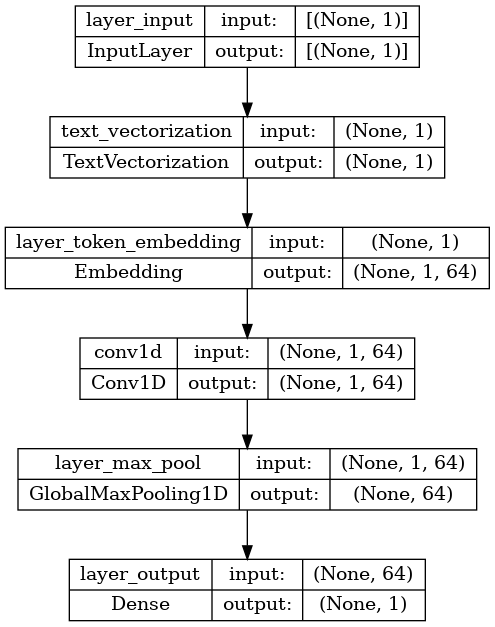

In [26]:
# Plot model_1
from tensorflow.keras.utils import plot_model
plot_model(model_1, show_shapes=True)

In [27]:
# import WandbCallback
from wandb.keras import WandbCallback

# Setup wandb init dan config
wb.init(project='ColorSkim',
        entity='jpao',
        name='model_1_Conv1D_embed',
        config={'epochs': 3,
                'n_layers': len(model_1.layers)})

# Fit model_1
hist_model_1 = model_1.fit(train_dataset,
                           epochs=wb.config.epochs,
                           validation_data=test_dataset,
                           callbacks=[WandbCallback()])

wandb: Currently logged in as: jpao. Use `wandb login --relogin` to force relogin


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'NoneType' object has no attribute 'name'
Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`
Epoch 1/3


2022-07-07 02:20:20.526025: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-07-07 02:20:20.526102: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2022-07-07 02:20:20.526441: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2022-07-07 02:20:20.529273: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-07-07 02:20:20.530147: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-07-07 02:20:20.530878: I tensorflow/stream_executor/cuda/cuda_gpu_exec

1419/1419 [==============================] - ETA: 0s - loss: 0.0739 - accuracy: 0.9833

wandb: ERROR Can't save model in the h5py format. The model will be saved as W&B Artifacts in the SavedModel format.


INFO:tensorflow:Assets written to: /home/jpao/ColorSkim/wandb/run-20220707_022010-sbtcupfj/files/model-best/assets


INFO:tensorflow:Assets written to: /home/jpao/ColorSkim/wandb/run-20220707_022010-sbtcupfj/files/model-best/assets
wandb: Adding directory to artifact (/home/jpao/ColorSkim/wandb/run-20220707_022010-sbtcupfj/files/model-best)... Done. 0.0s


1419/1419 [==============================] - 131s 91ms/step - loss: 0.0739 - accuracy: 0.9833 - val_loss: 0.0269 - val_accuracy: 0.9932 - _timestamp: 1657135348.0000 - _runtime: 138.0000
Epoch 2/3
1419/1419 [==============================] - ETA: 0s - loss: 0.0178 - accuracy: 0.9951

INFO:tensorflow:Assets written to: /home/jpao/ColorSkim/wandb/run-20220707_022010-sbtcupfj/files/model-best/assets


INFO:tensorflow:Assets written to: /home/jpao/ColorSkim/wandb/run-20220707_022010-sbtcupfj/files/model-best/assets
wandb: Adding directory to artifact (/home/jpao/ColorSkim/wandb/run-20220707_022010-sbtcupfj/files/model-best)... Done. 0.0s


1419/1419 [==============================] - 132s 93ms/step - loss: 0.0178 - accuracy: 0.9951 - val_loss: 0.0266 - val_accuracy: 0.9931 - _timestamp: 1657135481.0000 - _runtime: 271.0000
Epoch 3/3
1419/1419 [==============================] - ETA: 0s - loss: 0.0157 - accuracy: 0.9957

INFO:tensorflow:Assets written to: /home/jpao/ColorSkim/wandb/run-20220707_022010-sbtcupfj/files/model-best/assets


INFO:tensorflow:Assets written to: /home/jpao/ColorSkim/wandb/run-20220707_022010-sbtcupfj/files/model-best/assets
wandb: Adding directory to artifact (/home/jpao/ColorSkim/wandb/run-20220707_022010-sbtcupfj/files/model-best)... Done. 0.0s


1419/1419 [==============================] - 134s 95ms/step - loss: 0.0157 - accuracy: 0.9957 - val_loss: 0.0261 - val_accuracy: 0.9934 - _timestamp: 1657135615.0000 - _runtime: 405.0000


In [28]:
# Evaluasi model_1
model_1.evaluate(test_dataset)

355/355 [==============================] - 20s 55ms/step - loss: 0.0261 - accuracy: 0.9934


[0.026092415675520897, 0.9933926463127136]

In [29]:
# Membuat prediksi berdasarkan model_1
model_1_pred_prob = model_1.predict(test_dataset)
model_1_pred_prob[:10]

355/355 [==============================] - 11s 31ms/step


array([[4.3239837e-05],
       [5.4787615e-05],
       [5.0116128e-06],
       [9.9752456e-01],
       [9.9969471e-01],
       [6.2631939e-06],
       [1.3910768e-04],
       [5.1418473e-03],
       [7.9536141e-05],
       [9.9527943e-01]], dtype=float32)

In [30]:
# Mengkonversi model_1_pred_prob ke dalam label
model_1_pred = tf.squeeze(tf.round(model_1_pred_prob))
model_1_pred

<tf.Tensor: shape=(11351,), dtype=float32, numpy=array([0., 0., 0., ..., 1., 1., 0.], dtype=float32)>

In [31]:
# Menghitung metriks dari model_1
model_1_metrik = hitung_metrik(target=test_label_encode,
                              prediksi=model_1_pred)
model_1_metrik

{'akurasi': 0.9933926526297242,
 'presisi': 0.9933933084981195,
 'recall': 0.9933926526297242,
 'f1-score': 0.9933906657093607}

## Model 2: Transfer Learning pretrained feature exraction menggunakan Universal Sentence Encoder (USE)

In [32]:
# Download pretrained USE
import tensorflow_hub as hub
tf_hub_embedding = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                                  trainable=False,
                                  name='universal_sentence_encoder')

2022-07-07 02:27:31.149806: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 34133760 exceeds 10% of free system memory.
2022-07-07 02:27:31.194014: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 34133760 exceeds 10% of free system memory.
2022-07-07 02:27:31.241037: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 34133760 exceeds 10% of free system memory.
2022-07-07 02:27:31.291239: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 34133760 exceeds 10% of free system memory.
2022-07-07 02:27:31.335002: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 34133760 exceeds 10% of free system memory.


In [33]:
# Melakukan tes pretrained embedding pada contoh kata
kata_acak = random.choice(train_kata)
print(f'Kata acak:\n {kata_acak}')
kata_embed_pretrain = tf_hub_embedding([kata_acak])
print(f'\nKata setelah embed dengan USE:\n{kata_embed_pretrain[0][:30]}\n')
print(f'Panjang dari kata setelah embedding: {len(kata_embed_pretrain[0])}')

Kata acak:
 RED


2022-07-07 02:27:38.112918: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory



Kata setelah embed dengan USE:
[ 0.01600757  0.01402897 -0.01220298  0.01839061  0.00956276 -0.04620995
 -0.05466102 -0.01094087  0.01047012  0.05296487 -0.01716384 -0.0536413
 -0.02454204  0.02216236 -0.02154933 -0.02527235 -0.03151204 -0.03525452
 -0.03291243 -0.05708157 -0.05215279 -0.00124074  0.02146175 -0.04888703
 -0.0026715   0.01022863 -0.02862517 -0.03544052  0.04984294 -0.02138548]

Panjang dari kata setelah embedding: 512


In [34]:
# Membuat model_2 menggunakan USE
inputs = layers.Input(shape=[], dtype=tf.string, name='layer_input')
layer_embed_pretrained = tf_hub_embedding(inputs)
x = layers.Conv1D(filters=64, kernel_size=5, padding='same', activation='relu')(tf.expand_dims(layer_embed_pretrained, axis=-1))
x = layers.GlobalMaxPooling1D(name='layer_max_pooling')(x)
outputs = layers.Dense(1, activation='sigmoid', name='layer_output')(x)
model_2 = tf.keras.Model(inputs=inputs, outputs=outputs, name='model_2_Conv1D_USE_embed')

In [35]:
# Ringkasan model_2
model_2.summary()

Model: "model_2_Conv1D_USE_embed"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer_input (InputLayer)    [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 tf.expand_dims (TFOpLambda)  (None, 512, 1)           0         
                                                                 
 conv1d (Conv1D)             (None, 512, 64)           384       
                                                                 
 layer_max_pooling (GlobalMa  (None, 64)               0         
 xPooling1D)                                                     
                                                                 
 layer_output (Dense)        (None, 1)    

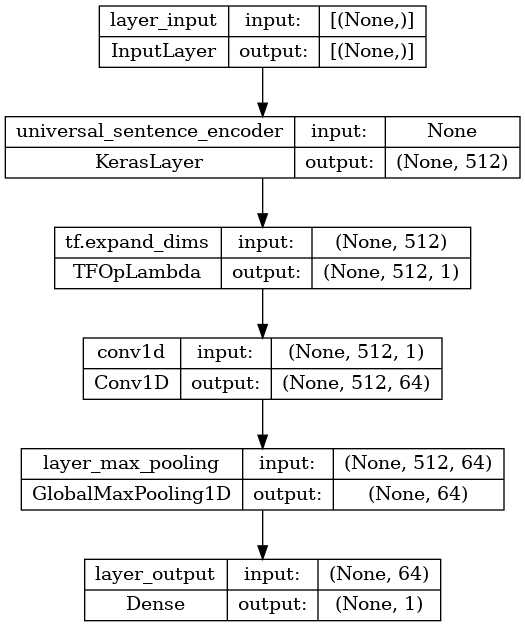

In [36]:
# Plot model_2
plot_model(model_2, show_shapes=True)

In [37]:
# Compile model_2
model_2.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [38]:
# Setup wandb init dan config
wb.init(project='ColorSkim',
        entity='jpao',
        name='model_2_Conv1D_USE_embed',
        config={'epochs': 3,
                'n_layers': len(model_2.layers)})

# Fit model_2
hist_model_2 = model_2.fit(train_dataset,
                           epochs=wb.config.epochs,
                           validation_data=test_dataset,
                           callbacks=[WandbCallback()])

accuracy,▁██
epoch,▁▅█
loss,█▁▁
val_accuracy,▃▁█
val_loss,█▅▁
GFLOPS,0.0
accuracy,0.99575
best_epoch,2
best_val_loss,0.02609
epoch,2
loss,0.0157


2022-07-07 02:27:54.414769: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-07-07 02:27:54.414863: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2022-07-07 02:27:54.415210: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2022-07-07 02:27:54.416953: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-07-07 02:27:54.417678: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-07-07 02:27:54.418442: I tensorflow/stream_executor/cuda/cuda_gpu_exec

: 

: 

In [ ]:
# Evaluate model_2
model_2.evaluate(test_dataset)

In [ ]:
# Test prediksi dengan model_1 (model_1_Conv1D_embed)
class_list = ['warna', 'bukan_warna']
article = 'PUMA XTG WOVEN PANTS PUMA BLACK-PUMA WHITE'
article_list = article.replace("-"," ").split()
model_test = model_1.predict(article.replace("-"," ").split())
for i in range(0, len(article_list)):
    print(f'Kata: {article_list[i]}\nPrediksi: {class_list[model_test[i]]}\n\n')

1/1 [==============================] - 0s 199ms/step


TypeError: only integer scalar arrays can be converted to a scalar index

In [ ]:
model_test

array([[1.5349576e-03],
       [7.1742781e-04],
       [1.4221472e-04],
       [2.2269943e-04],
       [1.5349576e-03],
       [9.9965119e-01],
       [1.5349576e-03],
       [9.9896502e-01]], dtype=float32)